### Exploratory data analysis

In [2]:
###Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [6]:
application_train = pd.read_csv('../data/application_train.csv', sep=',')

In [7]:
application_test = pd.read_csv('../data/application_test.csv', sep=',')

In [8]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


#### Distribution of the Target Column

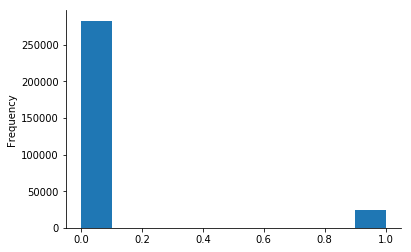

In [10]:
fig, ax = plt.subplots()

ax = application_train['TARGET'].plot.hist()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [11]:
application_train['TARGET'].value_counts()/application_train['TARGET'].count()*100

0    91.927118
1     8.072882
Name: TARGET, dtype: float64

Imbalanced class problem.

#### Missing values

In [12]:
 def missing_values_table(df):
    """
    Function to calculate missing values by column
    """
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [13]:
mis_val = missing_values_table(application_train)

In [16]:
mis_val.head(5)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


In [18]:
x = list(range(1, len(mis_val.index)+1))

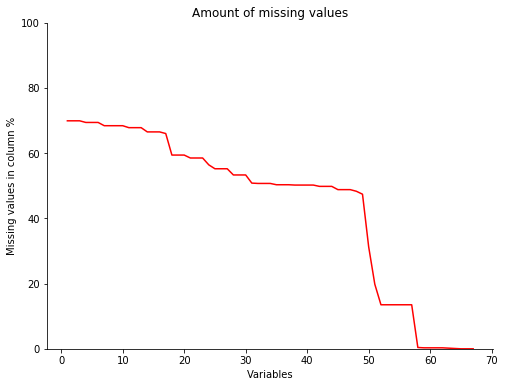

In [30]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x, mis_val['% of Total Values'].tolist(), 'r' )

ax.set_xlabel('Variables')
ax.set_ylabel('Missing values in column %')
ax.set_ylim([0,100])
ax.set_title('Amount of missing values')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Column Types

In [32]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [33]:
# Number of unique classes in each object column
application_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [ ]:
### Preprocess data

In [35]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [39]:
from sklearn.pipeline import make_pipeline, make_union, FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer

In [40]:
from sklearn.pipeline import _fit_one_transformer, _transform_one, _fit_transform_one
from scipy import sparse
from sklearn.externals.joblib import Parallel, delayed

Converting categorical data into numbers with with DictVectorizer Transformer. I use Pipeline convention. It benefits with more structured form and make the code reusable.

In [41]:
class PandasFeatureUnion(FeatureUnion):

    """
    Modified implementation od sklearn FeatureUnion, that return Pandas Dataframe
    """

    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(trans, weight, X, y,
                                        **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)


    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

In [42]:
class SelectorCatFeatColumns(BaseEstimator, TransformerMixin):

    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        col_list = []
        for col in X:
            if X[col].dtype == 'object':
                col_list.append(col)
        
        return X[col_list]
    
class SelectorNonCatFeatColumns(BaseEstimator, TransformerMixin):

    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        col_list = []
        for col in X:
            if X[col].dtype != 'object':
                col_list.append(col)
        
        return X[col_list]    
    

In [43]:
class DictVectorizerTransformer(TransformerMixin):

    def __init__(self):
        self.dv = None

    def fit(self, X, y=None):
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        return Xdum

In [44]:
pipeline = make_pipeline(
    
    PandasFeatureUnion([
    ('transNonCatFeat', make_pipeline(SelectorNonCatFeatColumns())),
    ('transCatFeat', make_pipeline(SelectorCatFeatColumns(), DictVectorizerTransformer()))
    
    ])
)

In [45]:
app_train_tr =  pipeline.fit_transform(application_train)
app_test_tr =  pipeline.transform(application_test)

Calculate correlation of variaables with target. 

In [46]:
correlations = app_train_tr.corr()['TARGET'].sort_values()

In [47]:
correlations.head(20)

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE=Higher education   -0.056593
CODE_GENDER=F                          -0.054704
NAME_INCOME_TYPE=Pensioner             -0.046209
ORGANIZATION_TYPE=XNA                  -0.045987
DAYS_EMPLOYED                          -0.044932
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
EMERGENCYSTATE_MODE=No                 -0.042201
HOUSETYPE_MODE=block of flats          -0.040594
AMT_GOODS_PRICE                        -0.039645
REGION_POPULATION_RELATIVE             -0.037227
ELEVATORS_AVG                          -0.034199
ELEVATORS_MEDI                         -0.033863
FLOORSMIN_AVG                          -0.033614
FLOORSMIN_MEDI                         -0.033394
WALLSMATERIAL_MODE=Panel               -0.033119
Name: TARGET, dtype:

In [51]:
app_train_tr['DAYS_BIRTH'] = abs(app_train_tr['DAYS_BIRTH'])

Explore variable with customers age.

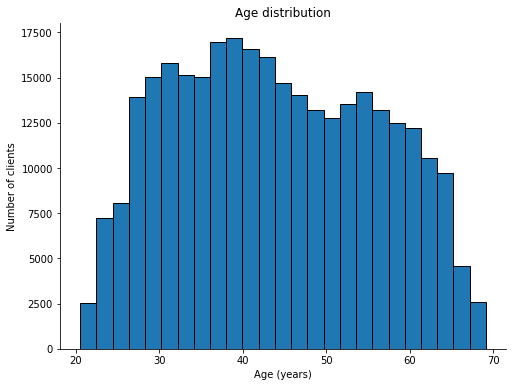

In [53]:
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(app_train_tr['DAYS_BIRTH']/365, 25, normed=False, edgecolor = 'k')

ax.set_xlabel('Age (years)')
ax.set_ylabel('Number of clients')
ax.set_title('Age distribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

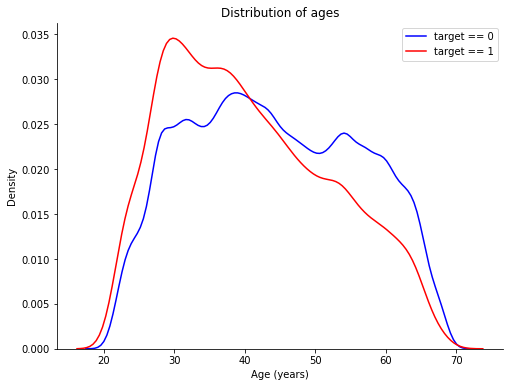

In [54]:
fig, ax = plt.subplots(figsize=(8,6))

# KDE plot of loans that were repaid on time
ax = sns.kdeplot(app_train_tr.loc[app_train_tr['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0', c='b')

# KDE plot of loans which were not repaid on time
ax = sns.kdeplot(app_train_tr.loc[app_train_tr['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1', c='r')
ax.set_xlabel('Age (years)')
ax.set_ylabel('Density')
ax.set_title('Distribution of ages')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Summary

This is very general exploratory data analysis. I just look at few basic aspects of dataset such as data size, type of variables, target distribution, missing values, age distribution. In-depth EDA would require much more exploration. Since the project is focused on diffrent aspects and dataset comes from kaggle competatation, I went through kernels with EDA published on kaggle to get to know more about dataset.  